In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot
import legacy.eigenstate_generator as eig_old

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median, mean
from matplotlib.ticker import FormatStrFormatter

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

small_ham_keys = []

for h in hamiltonians.keys():
    num_qubits = hamiltonians[h][1]
    if num_qubits < 10:
        small_ham_keys.append(h)

print(len(small_ham_keys))
small_ham_keys

12


['Be1_STO-3G_singlet',
 'H1-F1_STO-3G_singlet',
 'H1-Li1_STO-3G_singlet',
 'H1-O1_STO-3G_singlet',
 'H2-Be1_STO-3G_singlet',
 'H2_3-21G_singlet',
 'H2_6-31G_singlet',
 'Ne1_STO-3G_singlet',
 'H1-He1_STO-3G_singlet',
 'H3_STO-3G_singlet_1+',
 'H1-He1_3-21G_singlet_1+',
 'H3_3-21G_singlet_1+']

In [10]:
nc_mols={}

for speciesname in small_ham_keys:
    print(speciesname)
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol_rot = c.cs_vqe(hamiltonian, terms_noncon, num_qubits, rot_A=True)
    mol_unrot = c.cs_vqe(hamiltonian, terms_noncon, num_qubits, rot_A=False)
    G = mol_rot.generators()[0]
    A_rot = mol_rot.generators()[1]
    A_unrot = mol_unrot.generators()[1]
    
    eig_rot_proj = la.eigenstate_projector(A_rot, num_qubits)
    eig_unrot_proj = la.eigenstate_projector(A_unrot, num_qubits)
    
    eig_rot_mat = np.matrix(la.eigenstate_projector(A_rot, num_qubits))
    eig_unrot_mat = np.matrix(la.eigenstate_projector(A_unrot, num_qubits))
         
    gs_true=[]
    gs_rot_proj=[]
    gs_unrot_proj=[]
    
    for index in range(num_qubits):
        removed_index = list(range(0, index))
        removed_index.reverse()
        removed_generators = [list(G.keys())[i] for i in removed_index]
        Z_indices = [g.find('Z') for g in removed_generators]
        #nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

        new_ham_rot_noncon, new_ham_rot_context = mol_rot.move_generator(removed_generators)
        new_ham_unrot_noncon, new_ham_unrot_context = mol_unrot.move_generator(removed_generators)
        new_ham_rot_noncon_q = qonvert.dict_to_WeightedPauliOperator(new_ham_rot_noncon)
        new_ham_unrot_noncon_q = qonvert.dict_to_WeightedPauliOperator(new_ham_unrot_noncon)

        ham_rot_mat = new_ham_rot_noncon_q.to_matrix()
        ham_unrot_mat = new_ham_unrot_noncon_q.to_matrix()
        gs_true.append(get_ground_state(ham_rot_mat)[0])
        
        ham_rot_proj = eig_rot_mat*ham_rot_mat*eig_rot_mat.H
        ham_unrot_proj = eig_unrot_mat*ham_unrot_mat*eig_unrot_mat.H
        
        gs_rot_proj.append(get_ground_state(ham_rot_proj)[0])
        gs_unrot_proj.append(get_ground_state(ham_unrot_proj)[0])
        
        nc_mols[speciesname] = {'num_qubits':num_qubits,
                                  'gs_true':gs_true,
                                  'gs_rot_proj':gs_rot_proj,
                                  'gs_unrot_proj':gs_unrot_proj}
        

nc_mols

Be1_STO-3G_singlet
H1-F1_STO-3G_singlet
H1-Li1_STO-3G_singlet
H1-O1_STO-3G_singlet
H2-Be1_STO-3G_singlet
H2_3-21G_singlet
H2_6-31G_singlet
Ne1_STO-3G_singlet
H1-He1_STO-3G_singlet
H3_STO-3G_singlet_1+
H1-He1_3-21G_singlet_1+
H3_3-21G_singlet_1+


{'Be1_STO-3G_singlet': {'num_qubits': 5,
  'gs_true': [-14.351880476202043,
   -14.182174902190917,
   -13.346931730935895,
   -12.488747777578421,
   -10.916032798545967],
  'gs_rot_proj': [-14.35188047620202,
   -14.182143323216852,
   -13.346892252380611,
   -12.488598002782682,
   -10.915236623251179],
  'gs_unrot_proj': [-14.35188047620207,
   -14.182143323143942,
   -13.346892252307667,
   -12.488598002651802,
   -10.915236622890806]},
 'H1-F1_STO-3G_singlet': {'num_qubits': 8,
  'gs_true': [-103.55745152883426,
   -102.91839475990953,
   -101.12609567566669,
   -100.54798073615194,
   -99.15696343316415,
   -97.59113171456472,
   -82.99500549805146,
   -67.06391997180756],
  'gs_rot_proj': [-103.55745152883425,
   -102.91839475990949,
   -101.09343070445325,
   -100.54758922827415,
   -99.15695674747398,
   -97.59112603279281,
   -82.99500074167996,
   -67.06391589495912],
  'gs_unrot_proj': [-103.55745152883428,
   -102.91839475990898,
   -101.09343070445253,
   -100.5475892775

In [ ]:
nc_mols.pop('Ne1_STO-3G_singlet')

(3, 4)


Text(0.5, 0.98, 'Noncontextual ground state energy - restriction to +1-eigenspace versus exact')

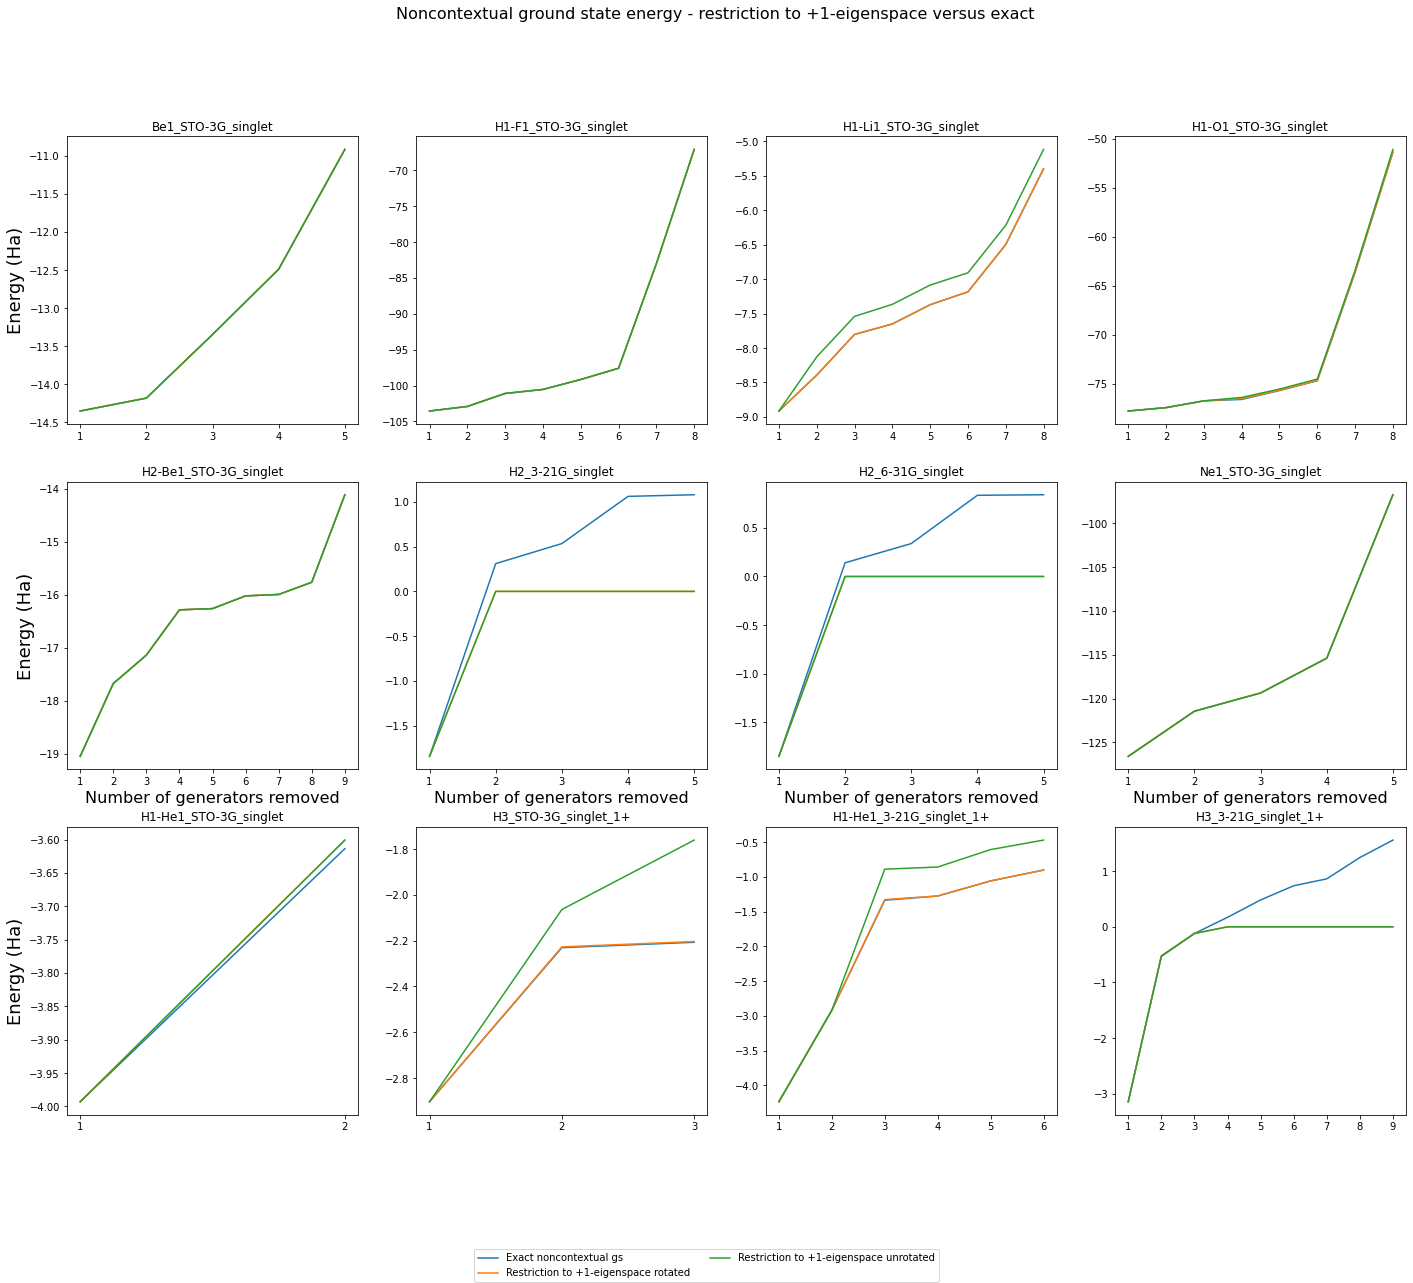

In [12]:
factors = la.factor_int(len(nc_mols))
print(factors)
if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))

for index, h in enumerate(nc_mols.keys()):
    grid = grid_pos[index]
    results = nc_mols[h]
    num_qubits = results['num_qubits']
    X=list(range(1, num_qubits+1))
    Y1=results['gs_true']
    Y2=results['gs_rot_proj']
    Y3=results['gs_unrot_proj']
    axs[grid].set_title(str(h))
    
    l1 = axs[grid].plot(X, Y1, label='Exact noncontextual gs')
    l2 = axs[grid].plot(X, Y2, label='Restriction to +1-eigenspace rotated')
    l3 = axs[grid].plot(X, Y3, label='Restriction to +1-eigenspace unrotated')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 1:
            axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2) 
fig.suptitle('Noncontextual ground state energy - restriction to +1-eigenspace versus exact', fontsize=16)

In [ ]:
#fig.savefig("plots/nc_+1_restriction_versus_exact", dpi=300)

In [5]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, list(range(num_qubits)))
    A = mol.A
    print(A)
    
    qubit_nums = range(1, num_qubits+1)
    gs_true = []
    gs_proj = []

    for n_q in qubit_nums:
        ham_red = mol.ham_reduced[n_q-1]
        ham_red_q = qonvert.dict_to_QubitOperator(ham_red)
        gs_red = get_ground_state(get_sparse_operator(ham_red_q, n_q).toarray())
        gs_true.append(gs_red[0])

        A_red = mol.reduce_anz_terms(A, n_q)
        eig_proj = la.eigenstate_projector(A_red, n_q)
        psi = gs_red[1]
        psi_proj = la.apply_projections(psi, [eig_proj])
        expct_proj = la.expectation(ham_red, psi_proj, n_q)
        gs_proj.append(expct_proj)
    
    proj_energy[speciesname] = {'qubit_nums':qubit_nums,
                               'gs_true':gs_true,
                               'gs_proj':gs_proj}

TypeError: 'list' object cannot be interpreted as an integer

In [6]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    Y1 = mol_results['gs_true']
    Y2 = mol_results['gs_proj']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    l1 = axs[grid].plot(X, Y1, label='Exact ground state energy')
    l2 = axs[grid].plot(X, Y2, label='Energy after projection into +1-eigenspace of A')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2)

fig.suptitle('Contextual subspace ground state energy - projection into +1-eigenspace versus exact', fontsize=16)
    

ZeroDivisionError: division by zero

# With CS-VQE reduced Hamiltonians

In [16]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    order = list(range(num_qubits))
    mol_rot = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, num_electrons=2, order=order, rot_A=True)
    mol_unrot = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, num_electrons=2, order=order, rot_A=False)
    A_rot = mol_rot.A
    A_unrot = mol_unrot.A
    print(speciesname)
    print('Unrotated:')
    print(mol_unrot.G)
    print(A_unrot, mol_rot.order)
    print('Rotated:')
    print(mol_rot.G)
    print(A_rot, mol_unrot.order)
    print('----------------------------')
    
    qubit_nums = range(1, num_qubits+1)
    gs_rot_true = []
    gs_unrot_true = []
    gs_rot_proj = []
    gs_unrot_proj = []

    for n_q in qubit_nums:
        ham_red_rot = mol_rot.ham_reduced[n_q-1]
        ham_red_rot_q = qonvert.dict_to_WeightedPauliOperator(ham_red_rot)
        ham_rot_mat = ham_red_rot_q.to_matrix()
        gs_rot_true.append(get_ground_state(ham_rot_mat)[0])
        
        ham_red_unrot = mol_rot.ham_reduced[n_q-1]
        ham_red_unrot_q = qonvert.dict_to_WeightedPauliOperator(ham_red_unrot)
        ham_unrot_mat = ham_red_unrot_q.to_matrix()
        gs_unrot_true.append(get_ground_state(ham_unrot_mat)[0])
        
        A_rot_red = mol_rot.reduce_anz_terms(A_rot, n_q)
        A_unrot_red = mol_unrot.reduce_anz_terms(A_unrot, n_q)
        
        eig_rot_mat = np.matrix(la.eigenstate_projector(A_rot_red, n_q))
        eig_unrot_mat = np.matrix(la.eigenstate_projector(A_unrot_red, n_q))
        
        
        ham_rot_proj = eig_rot_mat*ham_rot_mat*eig_rot_mat
        ham_unrot_proj = eig_unrot_mat*ham_unrot_mat*eig_unrot_mat.H
        
        gs_rot_proj.append(get_ground_state(ham_rot_proj)[0])
        gs_unrot_proj.append(get_ground_state(ham_unrot_proj)[0])
        
        #print(ham_red)
        #print(ham_mat)
        #print(A_red)
        #print(eig_mat)
        #print(ham_proj)
        #print('\n')
    
    proj_energy[speciesname] = {'qubit_nums':list(qubit_nums),
                                'gs_rot_true':gs_rot_true,
                                'gs_unrot_true':gs_unrot_true,
                                'gs_rot_proj':gs_rot_proj,
                                'gs_unrot_proj':gs_unrot_proj,
                                'diff_rot':[a-b for a, b in zip(gs_rot_proj, gs_rot_true)],
                                'diff_unrot':[a-b for a, b in zip(gs_unrot_proj, gs_unrot_true)]}

Be1_STO-3G_singlet
Unrotated:
{'ZIIII': -1.0, 'IZIII': -1.0, 'IIZII': 1.0, 'IIIIZ': -1.0}
{'IIIXI': -6.029070514886671e-09, 'IIIZI': -1.0} [3, 0, 1, 2, 4]
Rotated:
{'ZIIII': -1.0, 'IZIII': -1.0, 'IIZII': 1.0, 'IIIIZ': -1.0}
{'IIIZI': 1.0, 'IIIXI': -2.449293597636856e-16} [3, 0, 1, 2, 4]
----------------------------


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


H1-F1_STO-3G_singlet
Unrotated:
{'ZIIIIIII': -1, 'IZIIIIII': -1, 'IIIZIIII': -1, 'IIIIZIII': -1, 'IIIIIZII': -1, 'IIIIIIZI': -1, 'IIIIIIIZ': -1}
{'IIXZZZZZ': 2.0113630944690537e-07, 'IIZIIIII': -0.9999999999999798} [2, 0, 1, 3, 4, 5, 6, 7]
Rotated:
{'ZIIIIIII': -1.0, 'IZIIIIII': -1.0, 'IIIZIIII': -1.0, 'IIIIZIII': -1.0, 'IIIIIZII': -1.0, 'IIIIIIZI': -1.0, 'IIIIIIIZ': -1.0}
{'IIZIIIII': 1.0} [2, 0, 1, 3, 4, 5, 6, 7]
----------------------------
H1-Li1_STO-3G_singlet
Unrotated:
{'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': -1.0, 'IIIZIIII': 1.0, 'IIIIZIII': -1.0, 'IIIIIIZI': -1.0, 'IIIIIIIZ': -1.0}
{'IIIIIXZZ': -1.0575336511480974e-07, 'ZZIZIZIZ': 0.9999999999999944} [5, 0, 1, 2, 3, 4, 6, 7]
Rotated:
{'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': -1.0, 'IIIZIIII': 1.0, 'IIIIZIII': -1.0, 'IIIIIIZI': -1.0, 'IIIIIIIZ': -1.0}
{'IIIIIZII': 1.0, 'ZZIZIXZI': -2.220446049250313e-16} [5, 0, 1, 2, 3, 4, 6, 7]
----------------------------
H1-O1_STO-3G_singlet
Unrotated:
{'ZIIIIIII': 1, 'IZIIIIII':

Text(0.5, 0.95, 'Contextual subspace ground state energy - difference between unrestricted and after projection onto +1-eigenspace of A')

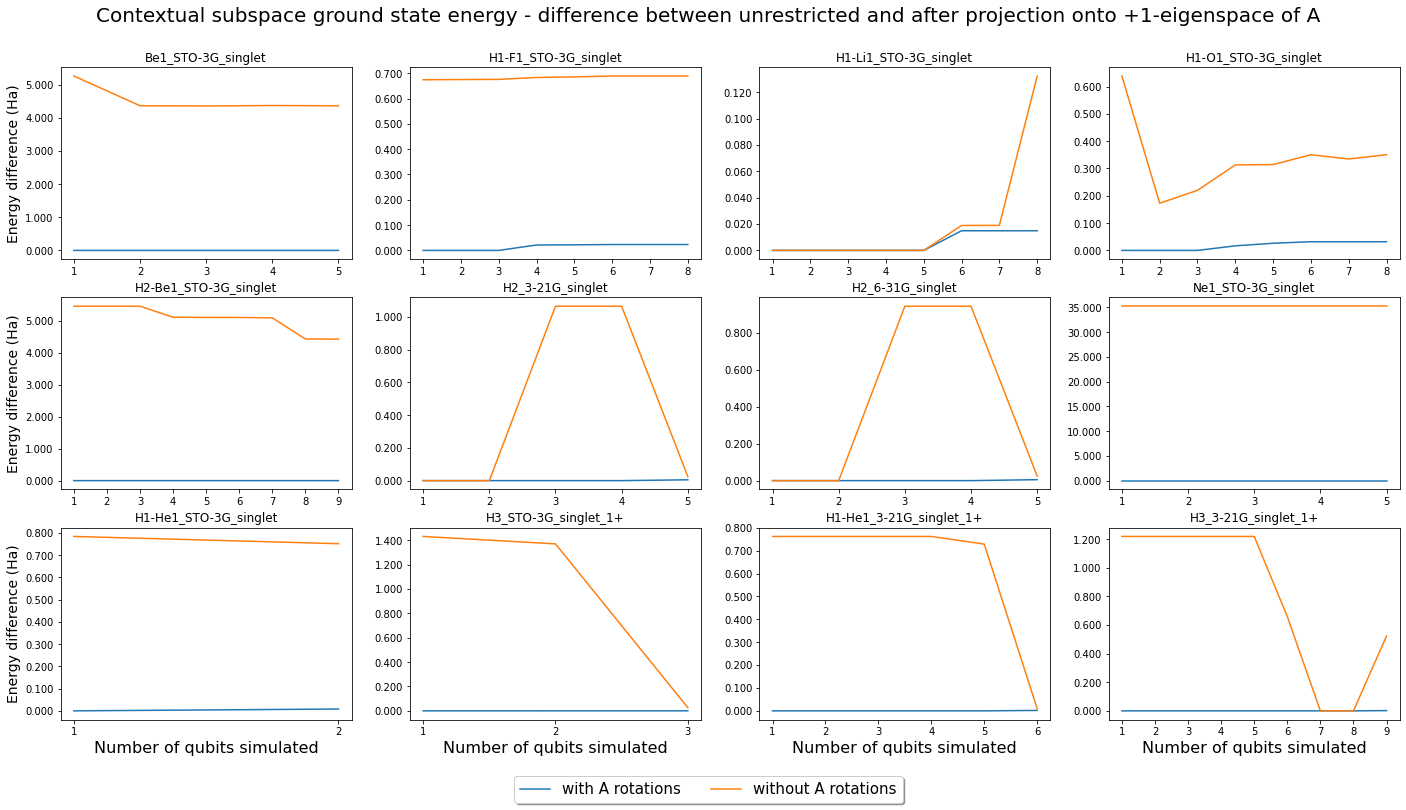

In [41]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],4*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    Y1 = mol_results['diff_rot']
    Y2 = mol_results['diff_unrot']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    l1 = axs[grid].plot(X, Y1, label='with A rotations')
    l2 = axs[grid].plot(X, Y2, label='without A rotations')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy difference (Ha)',fontsize=14)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels,
           fontsize=15,
           loc='lower center',bbox_to_anchor=(0.5, 0.02),
          fancybox=True, shadow=True, ncol=2)

fig.suptitle('Contextual subspace ground state energy - difference between unrestricted and after projection onto +1-eigenspace of A', 
             fontsize=20,
             y=0.95)
    

In [42]:
fig.savefig("plots/diff_gs_exact_versus_+1_restriction", dpi=300)

# Using generator removal tool

In [7]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)#, rot_A=True)
    A = mol.generators()[1]
    G = mol.generators()[0]
    print(G, A)
    
    qubit_nums = range(0, num_qubits)
    gs_noncon_true = []
    gs_context_true = []
    gs_noncon_proj = []
    gs_context_proj = []
    combined_cs_vqe = []

    for n_q in qubit_nums:
        order = list(range(num_qubits))
        order.reverse()
        ham_red = mol.reduced_hamiltonian(order=order, num_sim_q=n_q+1)
        ham_mat = qonvert.dict_to_WeightedPauliOperator(ham_red).to_matrix()
        exact_combined = get_ground_state(ham_mat)[0]
        combined_cs_vqe.append(exact_combined)
        
        removed_index = list(range(n_q))
        removed_index.reverse()
        removed_generators = [list(G.keys())[i] for i in removed_index]
        Z_indices = [g.find('Z') for g in removed_generators]
        print('removed:', removed_generators)
        #eig_ind = bit.unconstrain(initial_state, Z_indices)
        new_ham_noncon, new_ham_context = mol.move_generator(rem_gen=removed_generators)
        new_ham_noncon_q = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
        new_ham_context_q = qonvert.dict_to_WeightedPauliOperator(new_ham_context)
        
        ham_noncon_mat = new_ham_noncon_q.to_matrix()
        ham_context_mat = new_ham_context_q.to_matrix()
        
        gs_noncon_true.append(get_ground_state(ham_noncon_mat)[0])
        gs_context_true.append(get_ground_state(ham_context_mat)[0])
        
        #A_red = mol.reduce_anz_terms(A, n_q)
        eig_mat = np.matrix(la.eigenstate_projector(A, num_qubits))
        ham_noncon_proj = eig_mat*ham_noncon_mat*eig_mat
        ham_context_proj = eig_mat*ham_context_mat*eig_mat
        gs_noncon_proj.append(get_ground_state(ham_noncon_proj)[0])
        gs_context_proj.append(get_ground_state(ham_context_proj)[0])
    
    proj_energy[speciesname] = {'qubit_nums':list(qubit_nums),
                                'gs_noncon_true':gs_noncon_true,
                                'gs_noncon_proj':gs_noncon_proj,
                                'gs_context_true':gs_noncon_true,
                                'gs_context_proj':gs_context_proj,
                                'diff_context':[a-b for a, b in zip(gs_context_proj, gs_context_true)],
                                'diff_noncon':[a-b for a, b in zip(gs_noncon_proj, gs_noncon_true)],
                                'combined_cs_vqe':combined_cs_vqe,
                                'combined_proj':[a+b for a, b in zip(gs_noncon_proj, gs_context_proj)],
                                'combined_true':[a+b for a, b in zip(gs_noncon_true, gs_context_true)]}

{'ZIIII': -1.0, 'IZIII': -1.0, 'IIZII': 1.0, 'IIIIZ': -1.0} {'IIIXI': -6.029070514886671e-09, 'IIIZI': -1.0}
0
removed: []
1


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


removed: ['ZIIII']
2
removed: ['IZIII', 'ZIIII']
3
removed: ['IIZII', 'IZIII', 'ZIIII']
4
removed: ['IIIIZ', 'IIZII', 'IZIII', 'ZIIII']
{'ZIIIIIII': -1, 'IZIIIIII': -1, 'IIIZIIII': -1, 'IIIIZIII': -1, 'IIIIIZII': -1, 'IIIIIIZI': -1, 'IIIIIIIZ': -1} {'IIXZZZZZ': 2.0113630944690537e-07, 'IIZIIIII': -0.9999999999999798}
0
removed: []
1
removed: ['ZIIIIIII']
2
removed: ['IZIIIIII', 'ZIIIIIII']
3
removed: ['IIIZIIII', 'IZIIIIII', 'ZIIIIIII']
4
removed: ['IIIIZIII', 'IIIZIIII', 'IZIIIIII', 'ZIIIIIII']
5
removed: ['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IZIIIIII', 'ZIIIIIII']
6
removed: ['IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IZIIIIII', 'ZIIIIIII']
7
removed: ['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IZIIIIII', 'ZIIIIIII']
{'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': -1.0, 'IIIZIIII': 1.0, 'IIIIZIII': -1.0, 'IIIIIIZI': -1.0, 'IIIIIIIZ': -1.0} {'IIIIIXZZ': -1.0575336511480974e-07, 'ZZIZIZIZ': 0.9999999999999944}
0
removed: []
1
removed: ['ZIIIIIII']
2
removed: ['IZ

Text(0.5, 0.98, 'Contextual subspace ground state energy - projection into +1-eigenspace versus exact')

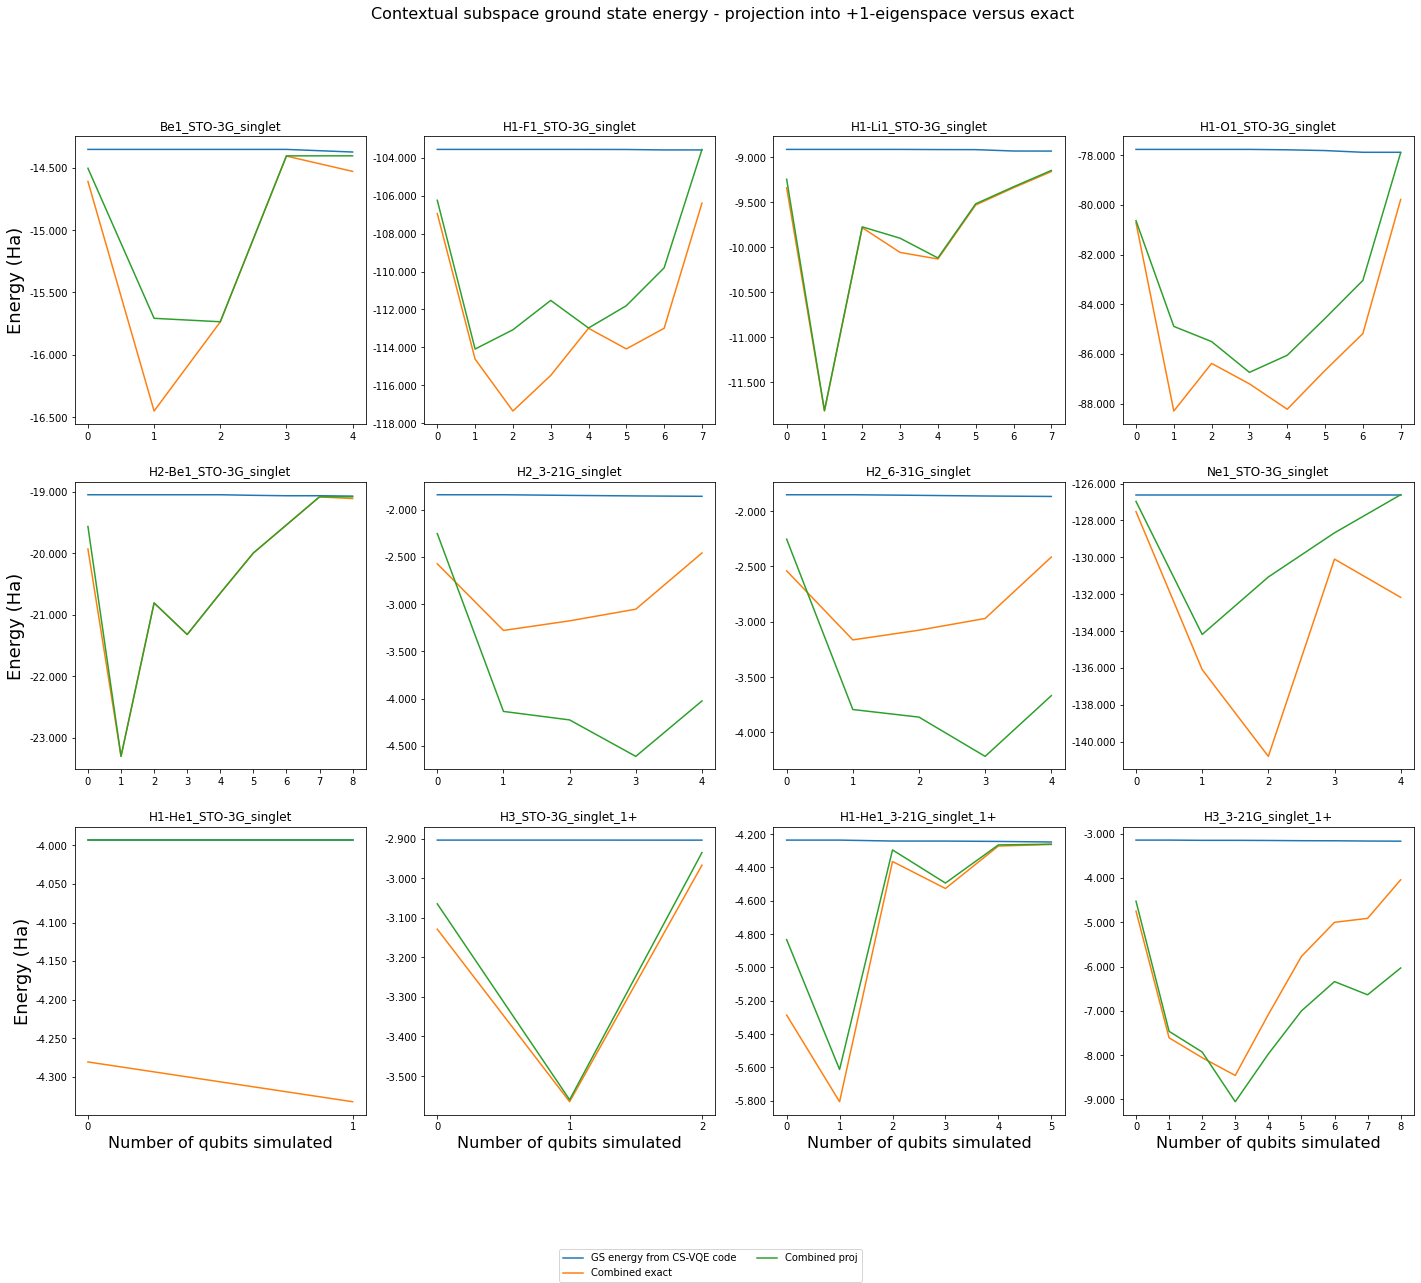

In [8]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    #Y1 = mol_results['gs_noncon_true']
    #Y2 = mol_results['gs_noncon_proj']
    #Y3 = mol_results['gs_context_true']
    #Y4 = mol_results['gs_context_proj']
    Y5 = mol_results['diff_noncon']
    Y6 = mol_results['diff_context']
    Y7 = mol_results['combined_cs_vqe']
    Y8 = mol_results['combined_true']
    Y9 = mol_results['combined_proj']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    #l1 = axs[grid].plot(X, Y1, label='Exact noncontextual ground state energy')
    #l2 = axs[grid].plot(X, Y2, label='Noncontextual energy after projection into +1-eigenspace of A')
    #l3 = axs[grid].plot(X, Y3, label='Exact contextual ground state energy')
    #l4 = axs[grid].plot(X, Y4, label='Contextual energy after projection into +1-eigenspace of A')
    #l5 = axs[grid].plot(X, Y5, label='Difference noncontextual')
    #l6 = axs[grid].plot(X, Y6, label='Difference contextual')
    l7 = axs[grid].plot(X, Y7, label='GS energy from CS-VQE code')
    l8 = axs[grid].plot(X, Y8, label='Combined exact')
    l9 = axs[grid].plot(X, Y9, label='Combined proj')
    
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2)

fig.suptitle('Contextual subspace ground state energy - projection into +1-eigenspace versus exact', fontsize=16)
    

In [21]:
hamiltonians['H3_STO-3G_singlet_1+']

['JW',
 3,
 {'III': -1.7512307459285525,
  'IIX': -0.023568152336180023,
  'IIZ': -0.017109477140260287,
  'IXI': 0.02356815233618002,
  'IXZ': 0.02356815233617983,
  'IYY': -0.07195737217001562,
  'IZI': -0.017109477140260287,
  'IZX': -0.023568152336179825,
  'IZZ': 0.31270210682950855,
  'XII': 0.01872992170537467,
  'XIX': 0.023568139980123585,
  'XIZ': 0.01872992170537467,
  'XXI': -0.023568139980123585,
  'XXX': 0.03597868636603963,
  'XXZ': -0.023568139980123585,
  'XYY': -0.03597868636603963,
  'XZI': 0.01872992170537467,
  'XZX': 0.023568139980123585,
  'XZZ': 0.01872992170537467,
  'YIY': 0.023568139980123585,
  'YXY': 0.03597868636603963,
  'YYI': -0.023568139980123585,
  'YYX': 0.03597868636603963,
  'YYZ': -0.023568139980123585,
  'YZY': 0.023568139980123585,
  'ZII': -0.45436486525596403,
  'ZIX': -0.023568152336180023,
  'ZIZ': 0.37110605476609787,
  'ZXI': 0.02356815233618002,
  'ZXZ': 0.02356815233617983,
  'ZYY': -0.07195737217001562,
  'ZZI': 0.37110605476609804,
  '

In [20]:
small_ham_keys

['Be1_STO-3G_singlet',
 'H1-F1_STO-3G_singlet',
 'H1-Li1_STO-3G_singlet',
 'H1-O1_STO-3G_singlet',
 'H2-Be1_STO-3G_singlet',
 'H2_3-21G_singlet',
 'H2_6-31G_singlet',
 'Ne1_STO-3G_singlet',
 'H1-He1_STO-3G_singlet',
 'H3_STO-3G_singlet_1+',
 'H1-He1_3-21G_singlet_1+',
 'H3_3-21G_singlet_1+']